参考资料：
+ https://blog.csdn.net/shebao3333/article/details/78808066 - 好
+ https://blog.csdn.net/xdzhangzhenhao/article/details/81147838
+ 

In [336]:
import os
import numpy as np 
import pandas as pd 
from cv2 import cv2 as cv
import matplotlib
import matplotlib.pyplot as plt 

ROOT_DIR = os.getcwd()
# IMG_DTR = os.path.join(ROOT_DIR, 'images')
DATA = os.path.join(ROOT_DIR, 'characters')

In [337]:
target_imgs = [ os.path.join(DATA, img_name) for img_name in os.listdir(DATA)] 
target_imgs.sort() # 升序，注意不能 listA = listA.sort(), sort没有返回值
target_imgs[0]

'/Users/rgmax/Desktop/Ex2_验证码识别/characters/0.png'

In [338]:
os.path.basename(target_imgs[1])

'0_1.png'

In [339]:
os.path.basename(target_imgs[1])[0]

'0'

In [340]:
captcha_imgs_folder = DATA
target_imgs = [ os.path.join(captcha_imgs_folder, img_name) 
                    for img_name in os.listdir(captcha_imgs_folder)] 
target_imgs.sort() # 升序，注意不能 listA = listA.sort(), sort没有返回值

img = cv.imread(target_imgs[0])
img.shape

(32, 26, 3)

In [341]:
img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
img_gray.shape

(32, 26)

In [342]:
img_gray0 = cv.imread(target_imgs[0], cv.IMREAD_GRAYSCALE)
img_gray0.shape

(32, 26)

In [343]:
img_gray0 = cv.resize(img_gray0, (20,20))
img_gray0.shape

(20, 20)

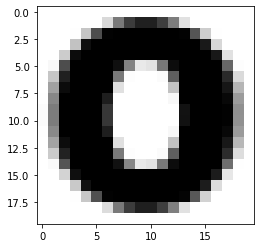

In [344]:
plt.imshow(img_gray0, cmap='gray')

In [345]:
# img_gray0 = np.expand_dims(img_gray0, axis=2) # 还是不能用sklearn训练
# img_gray0.shape

### 看了一下https://blog.csdn.net/xdzhangzhenhao/article/details/81147838

In [346]:
from sklearn import datasets
digits = datasets.load_digits()
X = digits.data
y = digits.target
X[111].shape

(64,)

[[ 0.  0.  1. 10.  9.  0.  0.  0.]
 [ 0.  0.  9. 15.  4.  0.  0.  0.]
 [ 0.  1. 16.  5.  0.  0.  0.  0.]
 [ 0.  4. 16.  1.  4. 14.  4.  0.]
 [ 0.  4. 16. 12. 14. 16.  5.  0.]
 [ 0.  0.  1.  7. 16.  9.  0.  0.]
 [ 0.  0.  0.  2. 16.  4.  0.  0.]
 [ 0.  0.  0. 10. 13.  0.  0.  0.]]


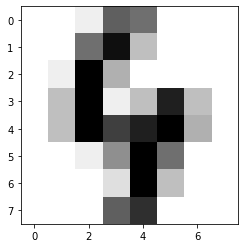

In [347]:
d = X[111].reshape(8,8)
plt.imshow(d, cmap='binary')
print(d)

In [348]:
# 看了一下https://blog.csdn.net/xdzhangzhenhao/article/details/81147838
# 中用sklean的knn传入的x_train的数组样式，下面用这个shape
img_gray0 = img_gray0.reshape(400,)
img_gray0.shape

(400,)

In [349]:
def gen_data_set(captcha_imgs_folder):
    '''
    此函数用于创建 样本集和对应标签集合,返回的数据集是np.array类型
    '''
    target_imgs = [ os.path.join(captcha_imgs_folder, img_name) 
                    for img_name in os.listdir(captcha_imgs_folder)] 
    target_imgs.sort() # 升序，注意不能 listA = listA.sort(), sort没有返回值
    data_set, label_set = [], []
    for captcha in target_imgs:
        img = cv.imread(captcha, cv.IMREAD_GRAYSCALE) # 以灰度图读入验证码/单个字符的图
        img = cv.resize(img, (20,20)) # 调整尺寸到20x20
        img = img.reshape(400,)  # reshape成一维数组（sklearn用kNN时需要的格式）
        data_set.append(img)
        label_set.append(os.path.basename(captcha)[0])
    return np.array(data_set), np.array(label_set)

data_set, label_set = gen_data_set(DATA)
# data_set[0]
# plt.imshow(data_set[8])

### 下面用sklearn的工具分割数据集

In [350]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data_set, label_set, test_size=0.25, random_state=40)
len(X_test) / len(X_train) , len(y_test) / len(y_train)

(0.3333333333333333, 0.3333333333333333)

### 下面用sklearn的kNN工具来做训练和预测

In [351]:
from sklearn.neighbors import KNeighborsClassifier

kNN_classifier = KNeighborsClassifier(n_neighbors=3)
kNN_classifier

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [352]:
kNN_classifier.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [353]:
predicted_result = kNN_classifier.predict(X_test)
predicted_result = pd.Series(predicted_result)

In [354]:
actual_result = pd.Series(y_test)
# actual_result

In [355]:
predicted_result == actual_result

0     True
1     True
2     True
3     True
4     True
      ... 
93    True
94    True
95    True
96    True
97    True
Length: 98, dtype: bool

In [356]:
def prediction_accuracy(predicted_results, actual_results):
    '''
    预测结果的正确率计算
    predicted_results, actual_results都需要是pandas的Series对象
    '''
    compare = predicted_results == actual_results # 返回一个Series对象
    return compare.value_counts().loc[True] /  compare.count() # 预测和实际值匹配的占所有的比例

In [357]:
prediction_accuracy(predicted_result, actual_result)

1.0

这是100%正确率是可以理解的，因为我自己生成的验证码分割出来的每个字符实际上都是一模一样的

### 下面我尝试自己实现一下kNN算法

In [358]:
a = np.array(
    [1,2,3,4,5,6,7]
)
b = np.array(
    [11,22,33,44,55,66,77]
)
np.square(b-a)

array([ 100,  400,  900, 1600, 2500, 3600, 4900])

In [359]:
a = [ 0, 1, 2, 3, 2]
a.index(2), list(enumerate(a))

(2, [(0, 0), (1, 1), (2, 2), (3, 3), (4, 2)])

In [360]:
# 获取list中最大的n个数的索引位置, 可以有重复的值
a = np.array([0,1,2,3,2])
np.sort(a), np.argsort([0,1,2,3,2]) # 用np的sort可以升序排序，argsort在升序排序后返回原来的索引

(array([0, 1, 2, 2, 3]), array([0, 1, 2, 4, 3]))

In [361]:
np.argsort(a)[-3:][::-1]

array([3, 4, 2])

In [362]:
a[[2,4]]

array([2, 2])

In [363]:
def judger(k_prediction):
    '''
    判决器，k_prediction是有权重的，索引最小代表该预测值和实际值相似度最大
    但是，可能出现如：k=5，k_prediction=（7, 1, 2, 2, 2），这样的情况，我定预测结果为2
    也就是，重复预测值个数 >= 预测值总数的2/3，则取该重复预测值
    '''
    k = len(k_prediction)
    tmp = list(k_prediction)
    [tmp.remove(i) for i in list(set(tmp))]
    duplication = set(tmp) # 找出预测值中重复元素
    if k_prediction[0] not in duplication: # 最接近的预测值不再重复出现的
        top_dupli = tmp[ min([ tmp.index(d) for d in duplication]) ]# 找出重复预测值中接近程度最高的值
        count = sum([ 1 for i in k_prediction if i==top_dupli]) # 统计较高相似度的重复预测值出现次数
        if count >= int(2/3 * k): # 如果较高相似度的中伏预测值出现次数 >= 预测值总数的2/3，则取该预测值
            return top_dupli    
    return k_prediction[0]

# judger( (5,2,2,3,3,3) )

In [364]:
def RG_kNN_classifier(feature_set_train, label_set_train, feature_set_test, k=3):
    '''
    所有的feature集合中的图像矩阵需要reshape成一维数组（传入前特征工程需要把图像先resize成20x20再reshape成（400,））
    feature_set_train, label_set_train, feature_set_test都必须是np.array
    '''
    label_set_Kpredict = []
    for test_feature in feature_set_test:
        distances = []
        for train_feature in feature_set_train:
            distances.append(
                np.sqrt(np.sum(np.square(test_feature - train_feature)))
            )
        topK = np.argsort(distances)[-k:][::-1] # [-k:]是提取最后k个（因为argsort是升序排序）,[::-1]则是将其反序
        label_set_Kpredict.append(
            tuple(label_set_train[list(topK)]) # 保存最接近的k个预测值
        )
    # return label_set_Kpredict
    # k个最接近的值，做一个投票器，利用投票器选出最终预测值
    label_set_single = [ judger(labels) for labels in label_set_Kpredict]
    return label_set_single, label_set_Kpredict


In [365]:
k = 9
int(2/3 * k)

6

In [366]:
# 找出list中重复元素的方法
a = [5,5, 5, 1, 1, 1, 2, 2, 3, 4]
b = list(set(a))
[a.remove(i) for i in b]
set(a)

{1, 2, 5}

In [367]:
RG_kNN_classifier(X_train,y_train,X_test, k=3)

['4',
 '5',
 '4',
 '8',
 '3',
 '8',
 '8',
 '4',
 '8',
 '4',
 '5',
 '4',
 '4',
 '3',
 '3',
 '5',
 '4',
 '3',
 '9',
 '8',
 '3',
 '9',
 '4',
 '8',
 '7',
 '4',
 '8',
 '4',
 '9',
 '4',
 '7',
 '8',
 '7',
 '4',
 '4',
 '8',
 '8',
 '7',
 '9',
 '5',
 '9',
 '3',
 '4',
 '3',
 '5',
 '4',
 '4',
 '7',
 '5',
 '5',
 '3',
 '4',
 '4',
 '8',
 '7',
 '4',
 '8',
 '5',
 '8',
 '7',
 '3',
 '4',
 '4',
 '4',
 '8',
 '3',
 '4',
 '8',
 '8',
 '9',
 '4',
 '9',
 '7',
 '7',
 '8',
 '8',
 '4',
 '4',
 '9',
 '9',
 '7',
 '4',
 '4',
 '5',
 '7',
 '8',
 '5',
 '3',
 '7',
 '8',
 '9',
 '3',
 '5',
 '8',
 '4',
 '3',
 '3',
 '7']